In [ ]:
# LIBRARIES
# Import the pandas library as pd
# Import the seaborn library as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Read in the "creditcard.csv" file from the folder into a dataframe called df.
# Use df.head() to get an idea of what the data looks like.
# Assuming the CSV file is in the same folder as your script or notebook
file_path = '/content/drive/MyDrive/creditcard.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
# Check for null values using df.isnull().sum().max()
max_null_values = df.isnull().sum().max()
print(f"The maximum number of null values in any column is: {max_null_values}")

The maximum number of null values in any column is: 0


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


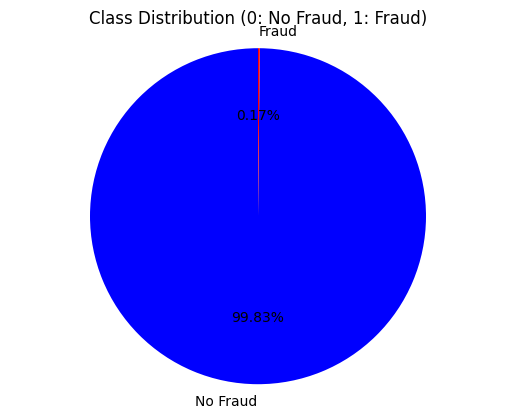

In [ ]:
# Print the percentage of non-fraudulent and fraudulent transactions
no_frauds_percentage = round(df['Class'].value_counts()[0] / len(df) * 100, 2)
frauds_percentage = round(df['Class'].value_counts()[1] / len(df) * 100, 2)
print('No Frauds', no_frauds_percentage, '% of the dataset')
print('Frauds', frauds_percentage, '% of the dataset')

# Create a visual representation of the class imbalance using a pie chart
labels = ['No Fraud', 'Fraud']
sizes = [no_frauds_percentage, frauds_percentage]
colors = ['blue', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
plt.axis('equal')
plt.show()

In [ ]:
# Scale the Transaction time and amount values
from sklearn.preprocessing import StandardScaler

# Scale the 'Time' and 'Amount' columns
scaler = StandardScaler()
df['Time_Scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
# Deal with the class imbalance
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = df[df['Class'] == 0]
minority_class = df[df['Class'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine the upsampled minority class with the majority class
df_upsampled = pd.concat([majority_class, minority_upsampled])

# Display the class distribution after upsampling
print(df_upsampled['Class'].value_counts())

# Alternatively, you can explore other techniques like downsampling or using class weights in your machine learning model.

0    284315
1    284315
Name: Class, dtype: int64


In [ ]:
# Prepare features and target variable
X = df_upsampled.drop('Class', axis=1)
y = df_upsampled['Class']

Accuracy: 0.9931853753759035
Precision: 0.9924474740217639
Recall: 0.993962793962794
F1 Score: 0.9932045560163792
AUC-PRC: 0.9991544718300088


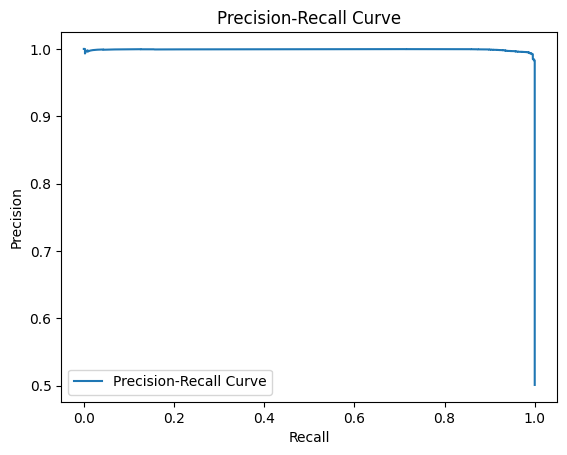

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc

# Assuming X and y are defined

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # for binary classification problems
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)
y_pred = model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate accuracy, precision, recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Calculate Area Under the Precision-Recall Curve (AUC-PRC)
auc_prc = average_precision_score(y_test, y_pred)
print(f"AUC-PRC: {auc_prc}")
precision_data, recall_data, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall_data, precision_data, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()